In [1]:
using IJulia, Plots, JuliaDB, RecommenderSystems, Statistics, CSV
import OnlineStats

In [6]:
f = CSV.File("/Users/guillaume/Downloads/ml-latest-small/ratings.csv", use_mmap=true)

CSV.File("/Users/guillaume/Downloads/ml-latest-small/ratings.csv", rows=100836):
Tables.Schema:
 :userId     Union{Missing, Int64}  
 :movieId    Union{Missing, Int64}  
 :rating     Union{Missing, Float64}
 :timestamp  Union{Missing, Int64}  

In [9]:
f.io

IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=2483723, maxsize=Inf, ptr=34, mark=-1)

In [16]:
OnlineStats.fit!(OnlineStats.Mean(), (row.rating for row in f))

Mean: n=100836 | value=3.50156

In [30]:
m = 10
i = 1
@time for row in CSV.File("/Users/guillaume/Downloads/ml-latest/ratings.csv", use_mmap=true)
    println(Rating(row.movieId, row.userId, row.rating))
    global i += 1
    if i >= m
        break
    end
end

Rating(item=307, user=1, value=3.5)
Rating(item=481, user=1, value=3.5)
Rating(item=1091, user=1, value=1.5)
Rating(item=1257, user=1, value=4.5)
Rating(item=1449, user=1, value=4.5)
Rating(item=1590, user=1, value=2.5)
Rating(item=1591, user=1, value=1.5)
Rating(item=2134, user=1, value=4.5)
Rating(item=2478, user=1, value=4.0)
 28.435802 seconds (801 allocations: 228.870 MiB, 8.90% gc time)


In [ ]:
function fit!(model::SVDModel{N,SGD}, csv::CSV.File; cb::Union{Function, Nothing}=nothing) where {N}
    solver::SGD = model.solver
    model.bias = mean(r.value for r in ratings)
    
    # initialize model's items and users sparse vectors from ratings
    items, users = Dict{Int64,Item{N}}(), Dict{Int64,User{N}}()
    foreach(ratings) do r
        items[r.item] = Item{N}(model.std)
        users[r.user] = User{N}(model.std)
    end
    model.items, model.users = sparsevec(items), sparsevec(users)
    
    for epoch in 1:solver.nepochs
        currentcost::Float64 = zero(Float64)
        for i in randperm(length(ratings))
            r = ratings[i]
            item::Item{N} = model.items[r.item]
            user::User{N} = model.users[r.user]

            e::Float64 = model.bias + item.bias + user.bias + dot(item.weights, user.weights) - r.value

            currentcost += abs2(e)
            
            item.weights .-= solver.lr .* 2 .* (e .* user.weights .+ solver.reg .* item.weights)
            user.weights .-= solver.lr .* 2 .* (e .* item.weights .+ solver.reg .* user.weights)
            item.bias -= solver.lr * 2 * (e + solver.reg * item.bias)
            user.bias -= solver.lr * 2 * (e + solver.reg * user.bias)
        end
        
        if cb !== nothing
            cb(epoch, currentcost)
        end
    end
end

In [24]:
df = loadtable("/Users/guillaume/Downloads/ml-latest-small/ratings.csv");

In [10]:
df[1:10]

Table with 10 rows, 4 columns:
userId  movieId  rating  timestamp
──────────────────────────────────
1       1        4.0     964982703
1       3        4.0     964981247
1       6        4.0     964982224
1       47       5.0     964983815
1       50       5.0     964982931
1       70       3.0     964982400
1       101      5.0     964980868
1       110      4.0     964982176
1       151      5.0     964984041
1       157      5.0     964984100

In [25]:
select(df, (:movieId))[1:5]

5-element Array{Int64,1}:
  1
  3
  6
 47
 50

In [26]:
summarize(mean, df, select=:rating)

(mean = 3.501556983616962,)

In [27]:
reduce(OnlineStats.Mean(), df, select=:rating)

Mean: n=100836 | value=3.50156

In [6]:
ratings = [Rating(row.movieId, row.userId, row.rating) for row in rows(df)];

## TODO: Make fit! accept an iterator or a stream as ratings, to cut preprocessing overhead. 

Processed epoch #100: 18.749530568735793
 10.250886 seconds (745.17 k allocations: 273.044 MiB, 1.31% gc time)


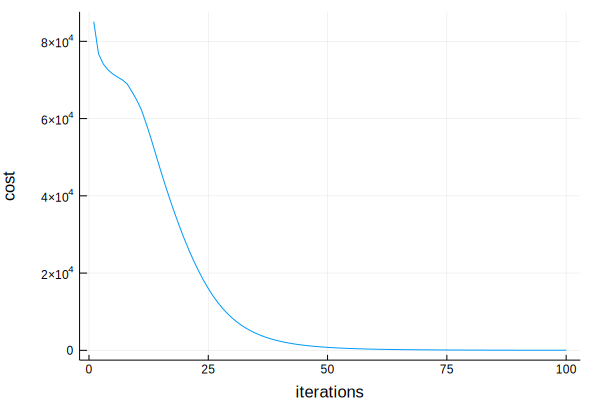

In [37]:
model = SVDModel(100, SGD(nepochs=100, lr=0.01, reg=0.0))
costs = Vector{Float64}()
@time fit!(model, ratings, cb=(epoch, cost) -> 
    begin
        IJulia.clear_output(true)
        println("Processed epoch #$(epoch): $(cost)")
        push!(costs, cost)
        end)
plot(costs, xlabel="iterations", ylabel="cost", legend=false)

In [ ]:
score(model, ratings)

### Custom Iterator

In [ ]:
struct Foo
    x::Int64
end

In [ ]:
function Base.iterate(f::Foo, state=(f.x, 0))
    len, count = state
    if count >= len
        return nothing
    end
    
    return (count+1, (f.x, count+1))
end

In [ ]:
f = Foo(10)
iterate(f)

for i in Foo(5)
    println(i)
end

In [ ]:
length(Foo(5))

In [ ]:
mutable struct Ratings{T}
    src::T
end

function Base.iterate(ratings::Ratings{IOStream}, state=ratings.src)
    s::IOStream = ratings.src
    
    if eof(s)
        return nothing
    end
    
    return (readline(s), ratings.src)
end

function Base.IteratorSize(t::Type{Ratings{IOStream}})
    return Base.SizeUnknown
end

In [ ]:
open("/Users/guillaume/Downloads/ml-latest-small/ratings.csv", "r") do f
    
    for line in Ratings(f)
        println(line)
    end
end